In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from scipy import stats
from scipy import mean

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# Use SQLAlchemy `create_engine` to connect to sqlite database.
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station=Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

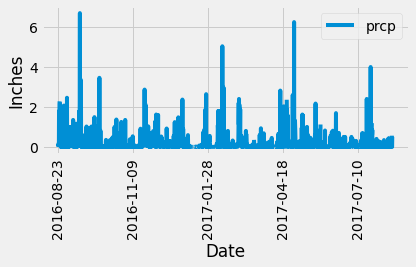

In [11]:
last_data= dt.datetime(2017,8,22)
year_ago = dt.datetime(2017,8,22)-dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

results=session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>=year_ago).\
        filter(Measurement.date<last_data).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date','prcp'])
df.set_index('date',inplace=True)
# Sort the dataframe by date
df.sort_values(by=['date'])
# Use Pandas Plotting with Matplotlib to plot the data
prcp_plot = df.plot()
prcp_plot.set_xlabel("Date")
prcp_plot.set_ylabel("Inches")
prcp_plot.tick_params(axis='x',rotation=90)

plt.tight_layout()
plt.show()


In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
print (df.describe())

              prcp
count  2017.000000
mean      0.177367
std       0.461568
min       0.000000
25%       0.000000
50%       0.020000
75%       0.130000
max       6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?

engine.execute('SELECT COUNT (DISTINCT station) FROM measurement').fetchall()

[(9,)]

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
lowest_temp = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station=='USC00519281').all()
highest_temp = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station=='USC00519281').all()
average_temp =  session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station=='USC00519281').all()
print("Lowest temperature: ", lowest_temp)
print("Highest temperature: ", highest_temp)
print("Average temperature: ", average_temp)

Lowest temperature:  [(54.0,)]
Highest temperature:  [(85.0,)]
Average temperature:  [(71.66378066378067,)]


In [16]:
# Choose the station with the highest number of temperature observations.

session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

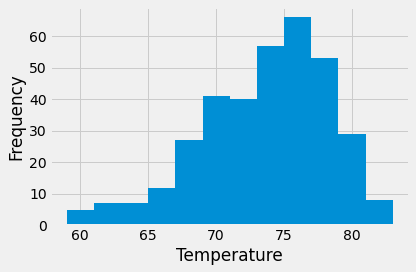

In [17]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_ob = session.query(Measurement.tobs).filter(Measurement.station=='USC00519281').\
    filter(Measurement.date>=year_ago).\
    filter(Measurement.date<last_data).all()
df_temp = pd.DataFrame(temp_ob, columns = ['temp'])
plt.hist(df_temp.temp,bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")


plt.tight_layout()
plt.show()

## Temperature Analysis

In [18]:
# Get all the temperature reocred in June and December
temp_in_Jun = session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date) == "06").all()
temp_in_Dec = session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date) == "12").all()


In [19]:
# Get the average temperature recorded in June
np.mean(temp_in_Jun)

74.94411764705882

In [20]:
# Get the average temperature recorded in June
np.mean(temp_in_Dec)

71.04152933421226

In [21]:
# Use unparied t-test to determine if the temperature in June and December 
# are statistics significant (because temperature in June and December are
# not depended on each other)

stats.ttest_ind(temp_in_Jun, temp_in_Dec)

Ttest_indResult(statistic=array([31.60372399]), pvalue=array([3.9025129e-191]))

### T-test Resulats Explanation
* P-value is less than 0.05, so we can reject the null hypothesis. 
* We can get the conclusion that there is a meaningful difference between temperature in June and in December

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

[(tmin,tavg,tmax)]=calc_temps('2017-01-01','2018-01-07')

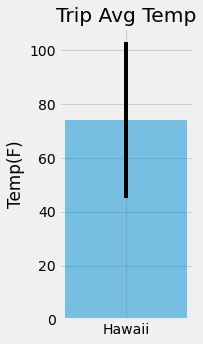

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig,ax = plt.subplots(figsize=(3,5))

ax.bar(np.arange(1),tavg, yerr=tmax-tmin, align='center',alpha=0.5,ecolor='black' )
ax.set_xticks(np.arange(1))
ax.set_xticklabels(['Hawaii'])
ax.set_ylabel("Temp(F)")
ax.set_title('Trip Avg Temp')
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()


In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date="2018-01-01"

i=0
travel_date_list=[]
while i<=6: 
    travel_date=dt.date(2018,1,1)+dt.timedelta(days=i)
    travel_date_list.append(travel_date.strftime("%m-%d"))
    i=i+1

travel_date_list


# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

tmin_list=[]
tavg_list=[]
tmax_list=[]
for date in travel_date_list:
    [(tmin,tavg,tmax)]=daily_normals(date)
    tmin_list.append(tmin)
    tavg_list.append(tavg)
    tmax_list.append(tmax)
print(tmin_list)
print(tavg_list)
print(tmax_list)


[62.0, 60.0, 62.0, 58.0, 56.0, 61.0, 57.0]
[69.15384615384616, 69.39622641509433, 68.9090909090909, 70.0, 67.96428571428571, 68.96491228070175, 68.54385964912281]
[77.0, 77.0, 77.0, 76.0, 76.0, 76.0, 76.0]


In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df_daily_normals = pd.DataFrame({'Date':travel_date_list,"Lowest_Temp":tmin_list,
                                "Average_Temp":tavg_list, "Max_Temp":tmax_list})
df=df_daily_normals.set_index('Date')
df


,Lowest_Temp,Average_Temp,Max_Temp
Date,,,
01-01,62.0,69.153846,77.0
01-02,60.0,69.396226,77.0
01-03,62.0,68.909091,77.0
01-04,58.0,70.000000,76.0
01-05,56.0,67.964286,76.0
01-06,61.0,68.964912,76.0
01-07,57.0,68.543860,76.0


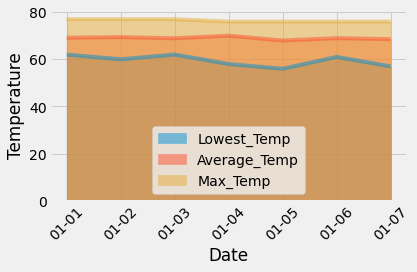

In [29]:
# plot an area plot for the daily normals
df.plot(kind='area', stacked=False)
plt.legend(loc='lower center')
plt.ylabel("Temperature")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()